In [1]:
%load_ext autoreload
%autoreload 2

> Matthias Lorthiois, M2.2 BIMS

# Projet : Apprentissage automatique

L'objectif de ce projet va être de déterminer quelle méthode de classification statistique vue en cours est la plus performante sur chacun de nos 3 jeux de données.

Pour reproduire ce notebook, toutes les implémentations et codes des différents modèles sont accessibles depuis mon [répértoire GitHub](https://github.com/mlorthiois/ml_project).

Tout d'abord, on importe les différents packages :
- Numpy et Pandas pour la manipulation des données et le calcul.
- La classe KFold de scikit-learn pour la validation croisée.
- Matplotlib pour la visualisation.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from dataset import Dataset

evaluation = pd.DataFrame(
    columns = ["name", "hyperparameters", "dataset", "top1_acc", "top2_acc"]
)

plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["axes.edgecolor"] = "0.15"

## Visualisation des jeux de données

La première étape, surtout lorsque le jeu de données est en 2D, est de visualiser leur répartition.

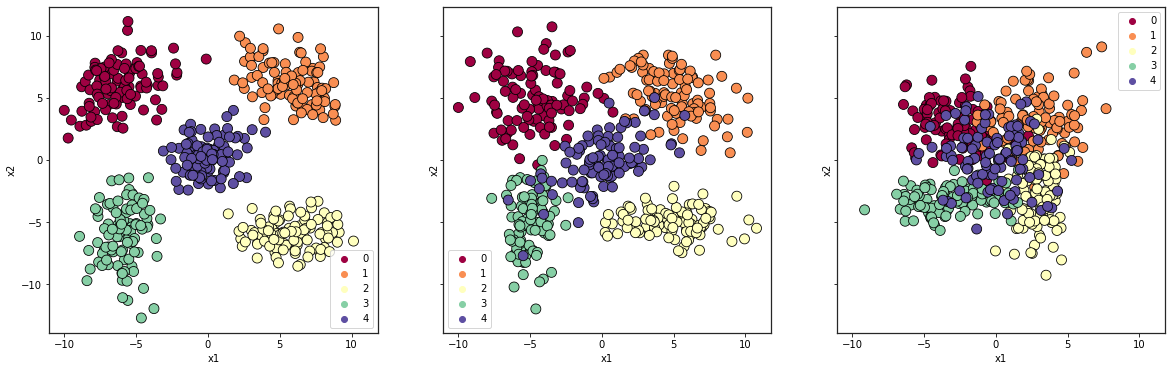

In [3]:
kf = KFold(n_splits=5, shuffle=True)

tp1, tp1_test = Dataset.from_file(
    ("data/data_tp1_app.txt", "data/data_tp1_dec.txt")
)

tp2, tp2_test = Dataset.from_file(
    ("data/data_tp2_app.txt", "data/data_tp2_dec.txt"),
    correction = [2, 1, 4, 0, 3]
)

tp3, tp3_test = Dataset.from_file(
    ("data/data_tp3_app.txt", "data/data_tp3_dec.txt"),
    correction = [4, 1, 0, 3, 2]
)

datasets = [(tp1, tp1_test), (tp2, tp2_test), (tp3, tp3_test)]

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(20, 6))
tp1.plot(ax=axs[0])
tp2.plot(ax=axs[1])
tp3.plot(ax=axs[2]);

On peut sur le premier jeu de données à gauche que les classes sont parfaitement séparées et distinctes. Ce qui n'est pas le cas sur les 2 autres jeux, qui présentent des données légèrement (jeu 2) ou fortement (jeu 3) mélangées et se superposant.

Il est donc facile de prédire que ces 2 jeux de données seront plus difficiles à prédire pour nos différents classificateurs, étant données que même une classification manuelle par l'Homme est difficile dans l'exemple 3.

> Une petite étape manuelle a été réalisée : elle consiste à homogénéiser les étiquettes des classes de 0 à 4, en suivant l'ordre des aiguilles d'une montre en partant d'en haut à gauche. Ceci facilitera la comparaison des visualisations.

## Estimation gaussienne

Le premier classificateur que l'on souhaite tester est l'estimation Gaussienne. Ce modèle, paramétrique, dispose dans notre de 2 hyperparamètres, qui sont les 2 distances à utiliser :
- Euclidienne
- Mahalanobis

La première distance testée a été la distance euclidienne.

### Distance Euclidienne

Tout d'abord, le modèle  a été entrainé sur chacun de nos 3 jeux d'entrainement, puis tester sur les jeux de test respectifs. La matrice de confusion obtenue sur les données tests est visible ci-dessous.

Nos jeux de données étant en 2D, il est possible également de représenter les limites de décision pour chaque classe de notre modèle. Pour obtenir ce graphique, le fond du graphique a été coloré selon la couleur de la **classe prédite** dans cette région par notre modèle, alors que les points représentent les données issues des jeux de test colorés selon leur **classe réelle**.

name     hyperparameters dataset  top1_acc  top2_acc
0  GaussianEstimator  distance=euclidian     tp1     0.992     1.000
1  GaussianEstimator  distance=euclidian     tp2     0.946     0.996
2  GaussianEstimator  distance=euclidian     tp3     0.728     0.892

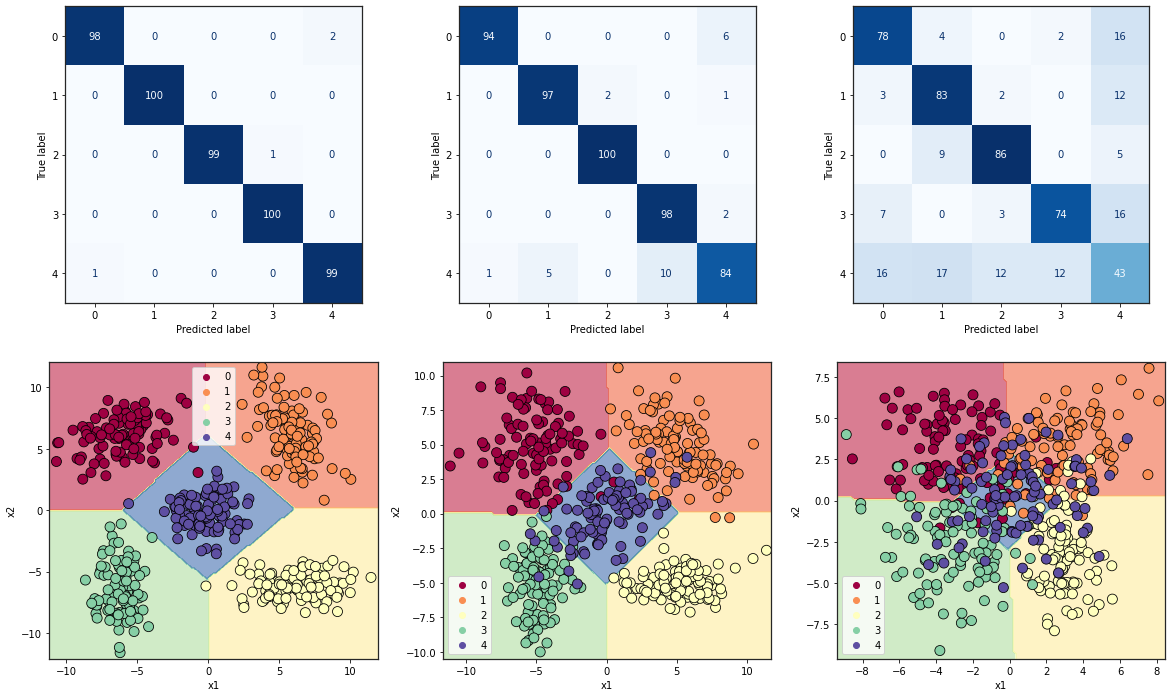

In [4]:
from gaussian import GaussianEstimator

results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = GaussianEstimator(distance="euclidian")
    model.train(train)
    results.append(model.evaluate(test, axs=(axs[0,i], axs[1,i])))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

- Le premier jeu de données est quasi-parfaitement classé par notre modèle, avec une précision Top1 proche de 100%. On voit des limites de classification qui étaient prévisibles manuellement.
- L'évaluation du modèle entrainé sur le deuxième jeu de données est très bon également, avec une précision Top1 de ~95% et Top2 de ~100%, où les seuls points mal classés semblent être de outliers de leur classe.
- Finalement, l'évluation du modèle entrainé le 3ème dataset est présence des performances honorables étant donné la difficulté de classification avec une précision Top1 et Top2 de 72% et 89% respectivement. Egalement, les limites de décision semblent logiques, et il est difficile de parvenir à faire mieux, même par l'Homme.

Par la suite, nous comparons notre modèle avec comme hyperparamètre la distance de Mahalanobis

### Distance de Mahalanobis

3 modèles ont été entrainés comme précédemment sur les 3 jeux de données, puis évalués.

name       hyperparameters dataset  top1_acc  top2_acc
0  GaussianEstimator  distance=mahalanobis     tp1     0.996     0.998
1  GaussianEstimator  distance=mahalanobis     tp2     0.946     0.994
2  GaussianEstimator  distance=mahalanobis     tp3     0.698     0.872

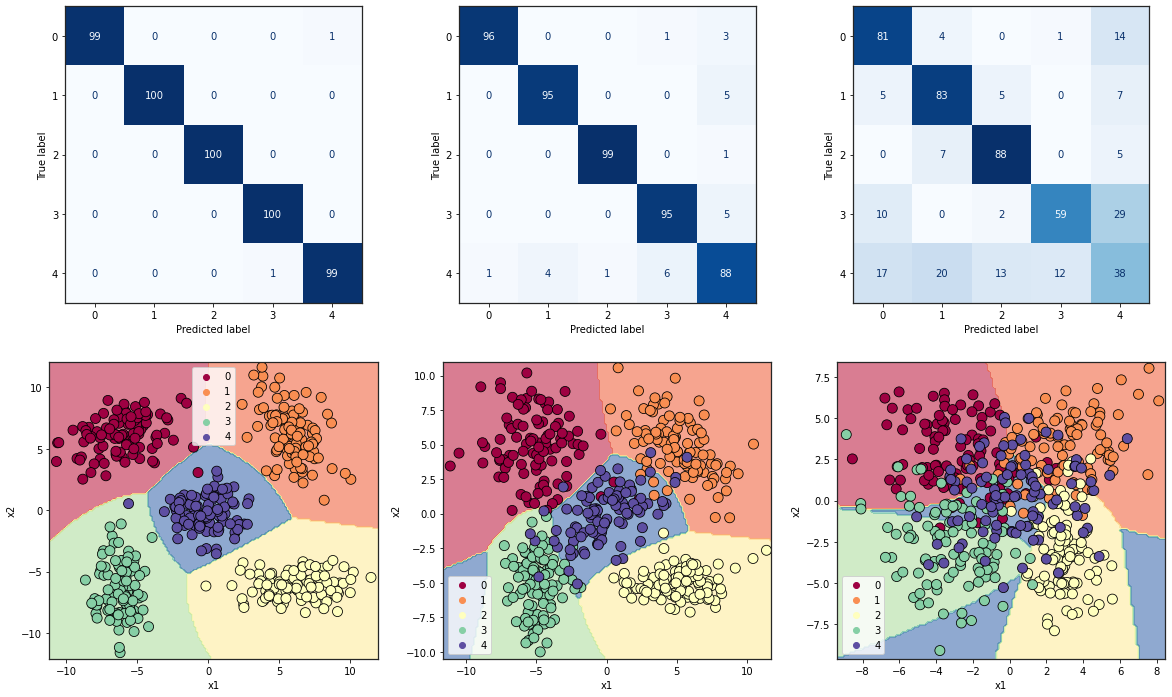

In [5]:
from gaussian import GaussianEstimator

results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = GaussianEstimator(distance="mahalanobis")
    model.train(train)
    results.append(model.evaluate(test, axs=(axs[0,i], axs[1,i])))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

On peut voir que les performances sur les 2 premiers datasets sont sensiblement identiques. En revanche, les limites de décisions sont différentes, plus arrondies.

Pour le 3ème jeu de données en revanche, les performances sont moins bonnes qu'avec la distance euclidiennes, et les limites de décisions sont différentes. On peut voir que la classe centrale possède des régions en bas et à droite du graphique. Ceci peut s'expliquer par le fait que la distance de Mahalanobis prend en compte la dispersion des données dans chaque classe. Hors, dans le jeu d'entrainement, la classe centrale est beaucoup plus dispersée et arrondie que les classes extérieures (notamment 2) qui est également plus haute que large. De cette façon, la distance située à droite de la classe 2 est attribuée à la classe 4 car plus large.

Afin de tester notre implémentation, nous comparons notre modèle avec celui proposé par Scikit-learn (distance euclidienne), uniquement sur le dataset le plus difficile à classer (3).

### Comparaison avec Scikit-learn

In [6]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = GaussianProcessClassifier()
gpc.fit(tp3.x, tp3.y)
gpc.score(tp3_test.x, tp3_test.y)

0.71

On peut voir que la performance est proche de la notre (0.72 contre 0.71 pour Scikit-learn), et confirme donc notre implémentation.

On peut donc passer à un autre modèle de classification : le modèles des K plus proches voisins.

## KPPV

Ce classificateur non-paramétrique va attribuer la classe majoritaire de ses $k$ plus proches voisins dans l'espace à 2D. Tout d'abord, nous allons initialiser, entrainer et tester un KPPV attribuant la classe du plus proche voisin de chaque point du jeu de test.

name hyperparameters dataset  top1_acc  top2_acc
0  KPPV             k=1     tp1     0.992     0.996
1  KPPV             k=1     tp2     0.920     0.968
2  KPPV             k=1     tp3     0.646     0.816

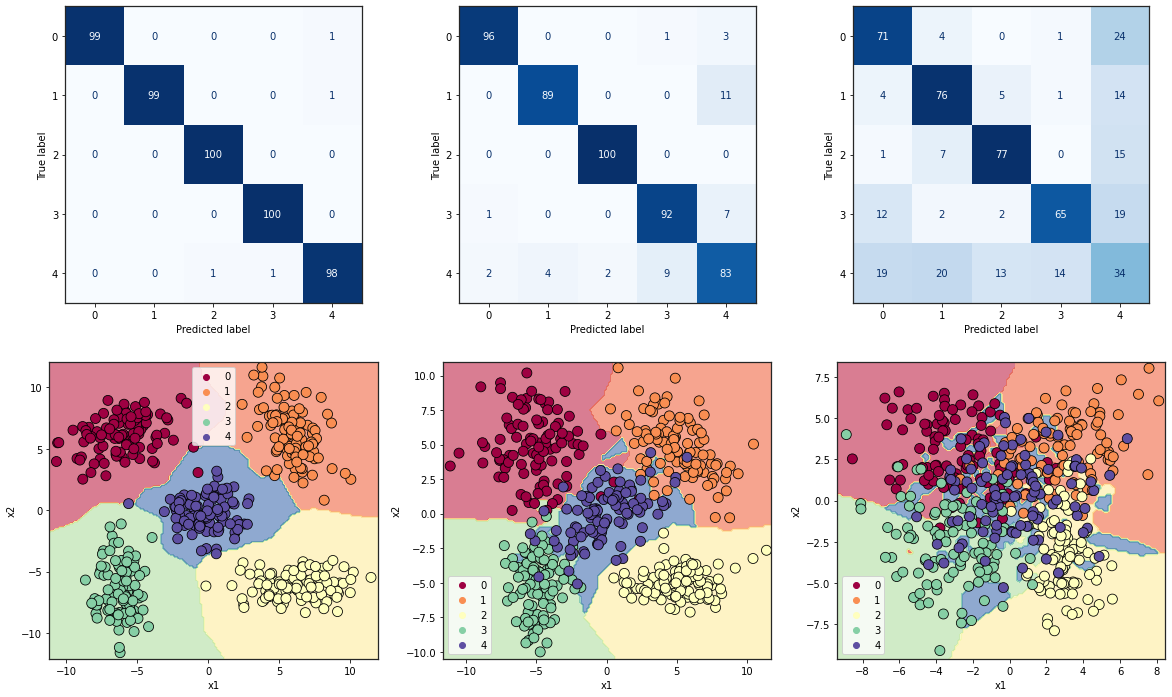

In [7]:
from kppv import KPPV

results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = KPPV(k=1)
    model.train(train)
    results.append(model.evaluate(test, axs=[axs[0,i], axs[1,i]]))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

- Sur le premier jeu de données, le taux de classification est très bon, avec 99% de précision Top1, tout comme l'estimation Gaussienne. 
- Sur le deuxième dataset, les résultats de classifications avec un 1 plus proche voisin montre un taux de bonne classification moins bon que celui du dataset 1 et aussi moins bon qu’avec la methode d’estimation gaussienne (92% de top 1 contre 94% avec l’estimation Gaussienne).
- La classification du troisième dataset avec un seul plus proche voisin n'est bonne que pour 65% des points. Ce résultat est moins bon que celui de l’estimation gaussienne (73%).

Il peut donc être intéressant d'identifier si les résultats sont meilleurs avec un nombre supérieur de voisins. Nous allons donc procéder à une recherche du meilleur hyperparamètre, allant de $k=1$ à $k=40$, de 2 en 2. Pour cela, et pour chaque $k$, le jeu d'entrainement est divisé en 5 parts égales, et 5 entrainements et évaluations sont réalisées avec des jeux différents.

![Kfold](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

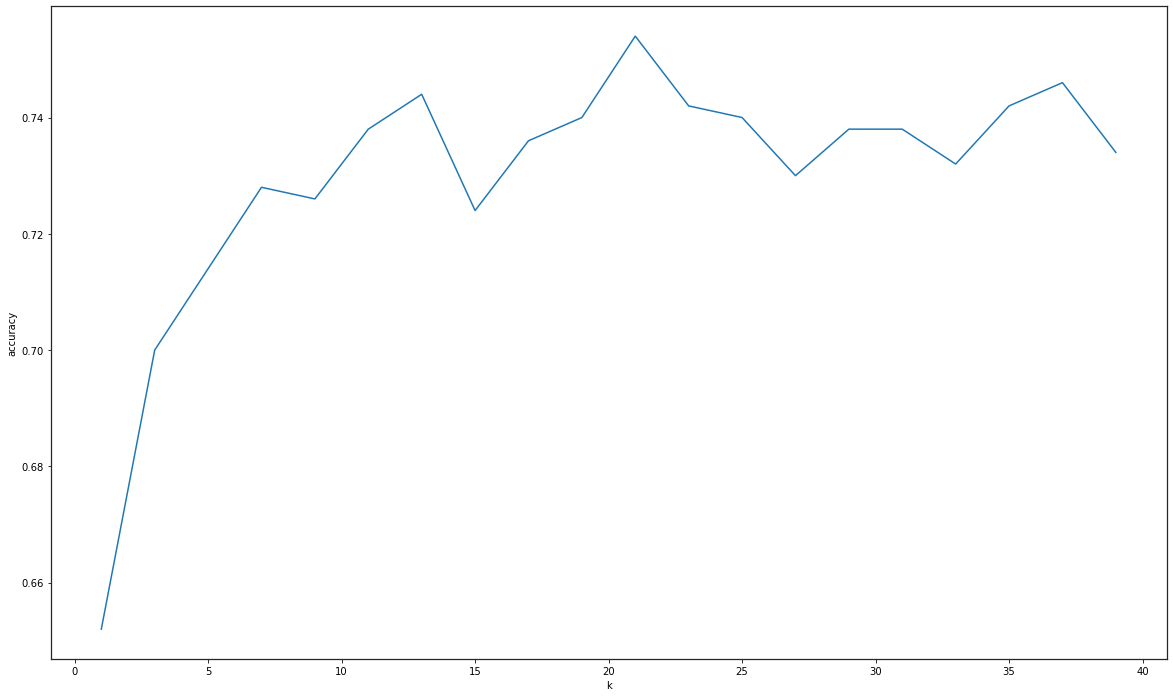

In [8]:
from kppv import KPPV

KPPV.hyperparameter_search(
    tp3, 
    kf,
    k=np.arange(1, 40, 2)
)

Nous pouvons voir sur cette figure que le meilleur $k$ semble être $k=21$ sur le 3ème dataset. Nous allons donc de nouveau réalisation l'entrainement et le test du KPPV avec $k=21$, sur les 3 jeux de données.

name hyperparameters dataset  top1_acc  top2_acc
0  KPPV            k=21     tp1     0.996     0.996
1  KPPV            k=21     tp2     0.946     0.992
2  KPPV            k=21     tp3     0.712     0.884

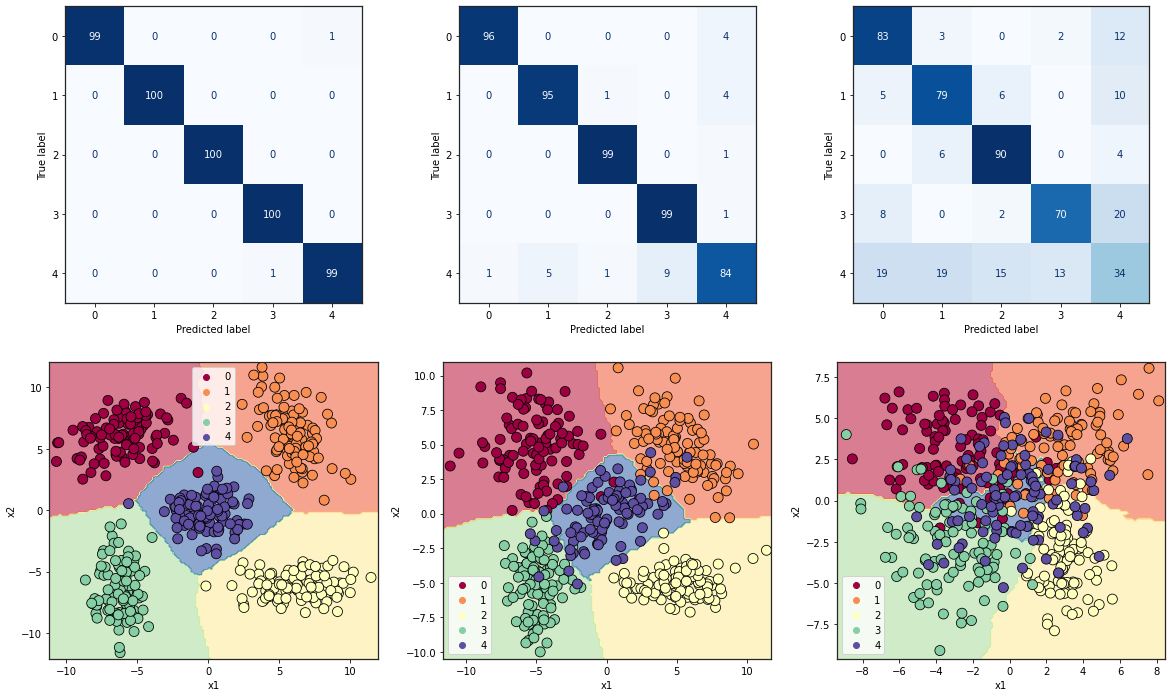

In [10]:
results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = KPPV(k=21)
    model.train(train)
    results.append(model.evaluate(test, axs=[axs[0,i], axs[1,i]]))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

On peut voir que le passage de $k=1$ à $k=21$ permet d'augmenter les performances de notre modèle sur les datasets 2 et 3, avec un passage de 0.92 à 0.95 et 0.64 à 0.71 respectivement. On remarque grâce aux matrices de confusions que c'est surtout la classe centrale qui est mieux classée avec l'augmentation du nombre de voisins.

On remarque également que même avec un nombre de voisins choisis de 21, les peroformances sur le jeu de données 2 et 3 sont inférieures à celles de l'estimation gaussienne à distance Euclidienne.

## Comparaison avec Scikit-Learn

Afin de voir si notre implémentation est correcte et proche de celle de Scikit-learn, les performances sur le dataset 3 ont été mesurées :

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(tp3.x, tp3.y)
knn.score(tp3_test.x, tp3_test.y)

0.708

On peut voir un passage de 0.712 à 0.708 donc les performances sont sensiblement identiques, et confirment notre modèle.

Le prochain classificateur étudié est le perceptron.

## Perceptron

Le perceptron est un classificateur statistique paramétrique basé sur le principe de séparation linéaire. Il va chercher un hyperplan discriminant une classe d'une autre, ou une classe de toutes les autres.

### One vs One

name hyperparameters dataset  top1_acc  top2_acc
0  Perceptron      versus=one     tp1     0.984     0.996
1  Perceptron      versus=one     tp2     0.648     0.990
2  Perceptron      versus=one     tp3     0.278     0.552

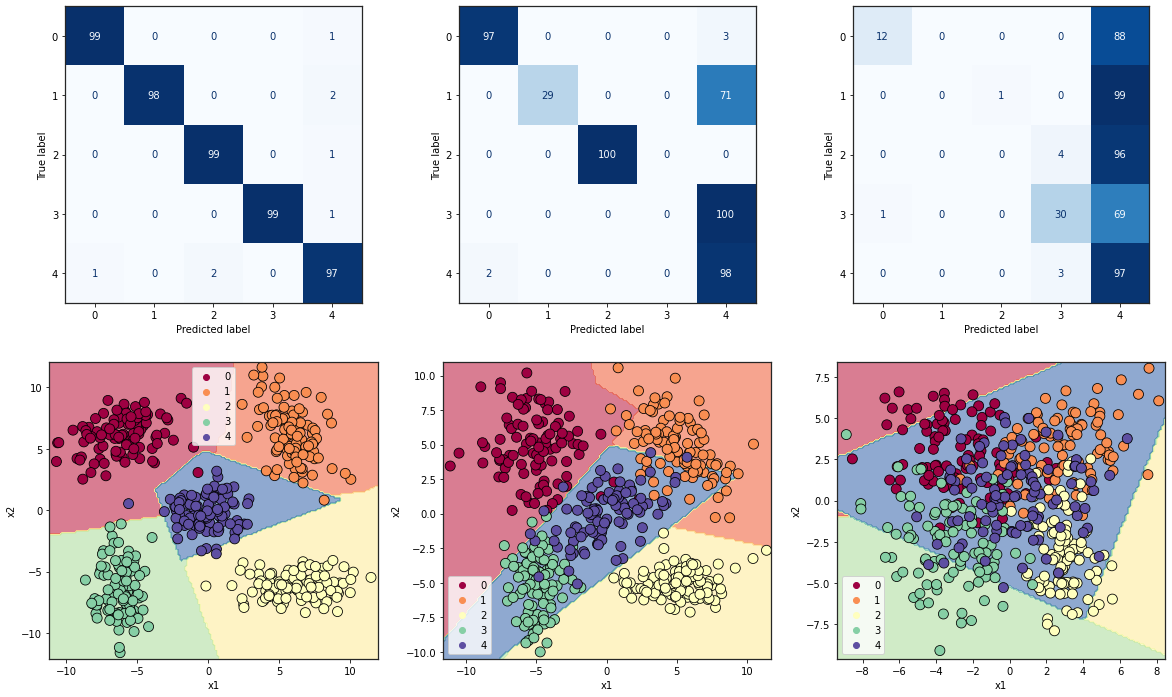

In [12]:
from perceptron import Perceptron

results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = Perceptron(vs="one", epochs=2000)
    model.train(train)
    results.append(model.evaluate(test, axs=[axs[0,i], axs[1,i]]))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

- On peut voir sur le premier jeu de données que les performances sont très bonnes, semblables aux autres méthodes car les classes peuvent être séparées linéairement.
- Sur le dataset 2, on peut voir que les classes 0, 2 et 4 sont bien classées, mais pas la classe 1 et 3. Cela peut s'expliquer par le fait que les données ne sont pas linéairement séparables, et donc il est difficile pour le modèle de trouver la meilleure droite possible. De plus, la classe 4 semble ici être prioritaire sur certaines régions du graphique alors qu'elle ne devrait pas, notamment en bas à gauche et près des points oranges. Les performances sont nettement moins bonnes que pour les précédents modèles.
- Le jeu de données 3 est le plus complexe, avec les classes les plus mélangés. Donc l’analyse des différentes classes et de leurs séparation linéaire est relativement mauvaise comme attendu, avec une impossibilité totale de trouver des droites efficaces. Au final, la très grande région centrale finit finit par attribuer tous les points à la classe 4, de façon beaucoup trop éparse. Après de multiples tests, même l'augmentation du nombre d’epochs n’améliore pas le modèle.

Pour améliorer les résultats, il aurait pu être envisageable, pour la décision, non plus de compter le nombre d'occurences de chaque classe dans les comparaisons, mais de calculer la "distance" du vecteur de résultats.
Exemple, la classe 1 apparait dans les comparaisons 1, 5, 6, 7, donc on pourrait calculer la distance du vecteur de sortie de toutes les comparaisons avec `[1, 0, 0, 0, 1, 1, 1, ...]`, et classer les points selon les distances.

### One vs All

Après avoir essayé de comparer chaque classe une à une nous allons tenter de voir si nous pouvons
trouver une séparation linéaire pouvant séparer une classe contre toutes les autres. Pour cela nous
allons supprimer la classe centrale de chaque jeu de données

name hyperparameters dataset  top1_acc  top2_acc
0  Perceptron      versus=all     tp1    0.9625    0.9950
1  Perceptron      versus=all     tp2    0.8225    0.9300
2  Perceptron      versus=all     tp3    0.3750    0.7075

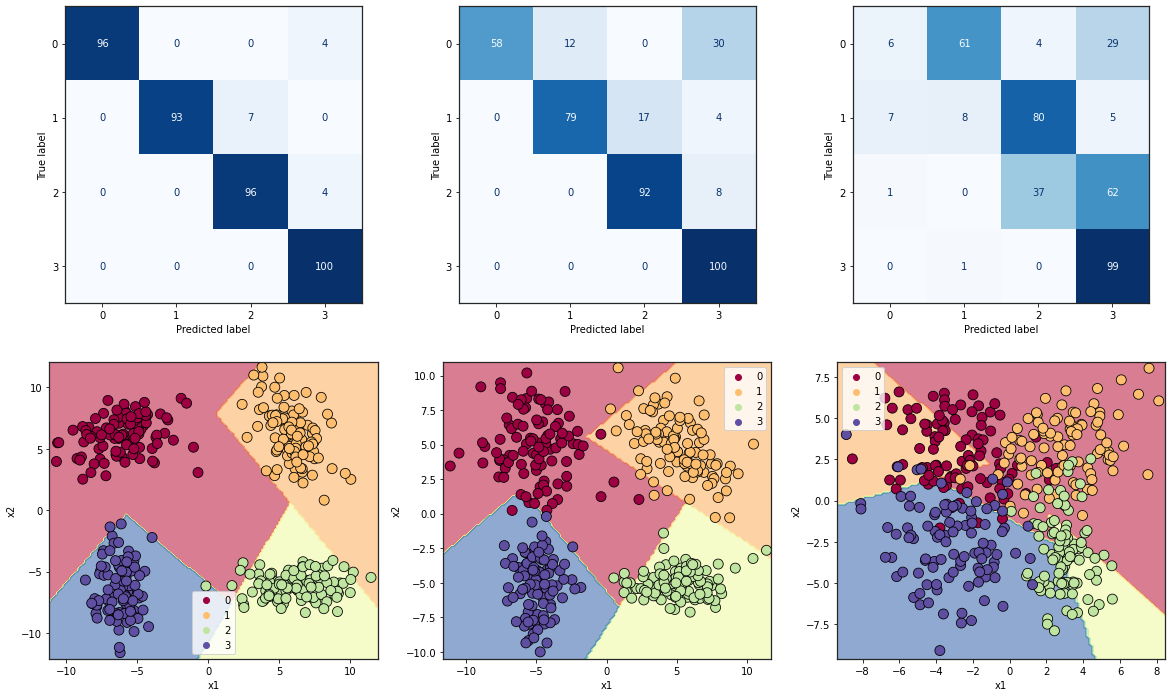

In [13]:
from perceptron import Perceptron

results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = Perceptron(vs="all", epochs=1000, class_to_exclude=4)
    model.train(train)
    results.append(model.evaluate(
        Dataset(test.x[test.y!=4], 
                test.y[test.y!=4], 
                name=f"tp{i+1}"), 
        axs=[axs[0,i], axs[1,i]]))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

- Le jeu de données 1 peut relativement bien être séparé par des droites entre les classes et le reste. En revanche le taux de bonne classification reste moins bon que les autres modèles, malgré le retrait de la classe centrale et des droites qui paraissent bien placées.
- Sur le 2ème dataset, les résultats sont meilleurs mais ceci peut s'expliquer par le fait que la classe la plus difficile à classer soit enlevée. En revanche, les droites semblent bien placées (hormis la région rouge en haut qui prend le dessus sur la classe orange).
- Finalement, le dernier dataset est toujours le plus difficile à classer, avec des régions oranges et vertes très petites, et qui expliquent donc les performances si faibles.


Afin de voir si notre modèle présente des performances ressemblantes à celles du modèle proposé par scikit-learn, nous allons comparer les précisions obtenues :

In [14]:
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(Perceptron(max_iter=1000))
clf.fit(tp3.x, tp3.y)
clf.score(tp3_test.x, tp3_test.y)

0.566

On peut voir que les performances sur le 3ème dataset de scikit-learn sont supérieures à notre modèle One vs One. Ceci peut s'expliquer par un choix d'implémentation différent, ou alors une erreur d'implémentation dans le mien, malgré un modèle qui semble fonctionnel pour les cas linéairement séparables.

Une fois le perceptron testé, nous pouvons passer aux fenêtres de Parzen.

## Parzen

Parson est une méthode non-paramétrique consistant à essayer d'approcher la densité de points par une fonction. Dans notre cas, la fonction uniforme et la fonction gaussienne.

### Fonction uniforme

name      hyperparameters dataset  top1_acc  top2_acc
0  Parzen  h=2, kernel=uniform     tp1     0.990     0.992
1  Parzen  h=2, kernel=uniform     tp2     0.948     0.988
2  Parzen  h=2, kernel=uniform     tp3     0.702     0.884

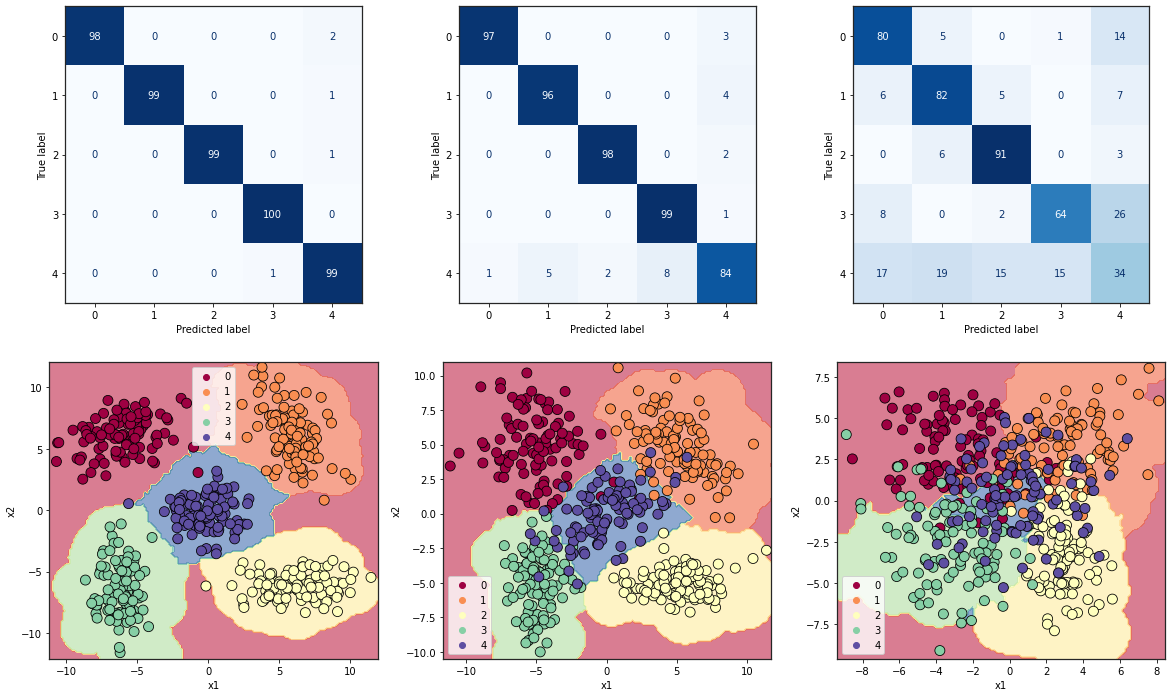

In [19]:
from parzen import Parzen

results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = Parzen(h=2, kernel="uniform")
    model.train(train)
    results.append(model.evaluate(test, axs=(axs[0,i], axs[1,i])))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

- On peut voir que les résultats sur le premier dataset sont très bons, à hauteur des autres modèles, avec des limites de décisions pertinentes.
- De la même façon, seule la classe 4 centrale présente des performances inférieure sur le 2ème dataset, à cause notamment de ses points pouvant être considérés comme des outliers, sinon les performances sont proches des modèles précédents.
- Enfin, avec une précision Top1 de 70%, le modèle sur le dataset 3 présente une performance honorable, à hauteur des anciens modèles, avec des limites de décisions bien placées.

Nous allons maintenant comparer avec une fonction gaussienne.

## Fonction gaussienne

name       hyperparameters dataset  top1_acc  top2_acc
0  Parzen  h=2, kernel=gaussian     tp1     0.996     0.998
1  Parzen  h=2, kernel=gaussian     tp2     0.952     0.996
2  Parzen  h=2, kernel=gaussian     tp3     0.724     0.886

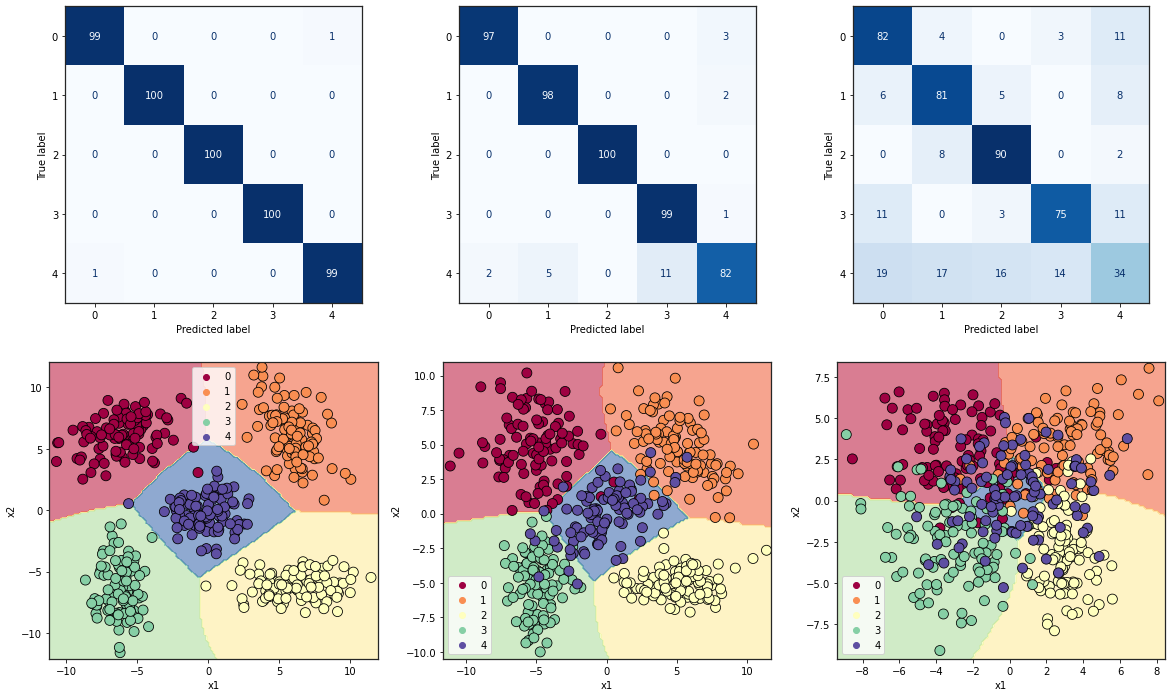

In [20]:
from parzen import Parzen

results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = Parzen(h=2, kernel="gaussian")
    model.train(train)
    results.append(model.evaluate(test, axs=(axs[0,i], axs[1,i])))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

De la même façon, les résultats semblent proches que lors de l'utilisation de la fonction uniforme sur les 3 datasets. Nous allons donc faire une recherche d'hyperparamètre, et faire varier $h$ sur les 2 fonctions disponibles, pour identifier le modèle le plus performant sur le jeu de données le plus difficile à classer : le 3.

## Recherche du meilleur modèle

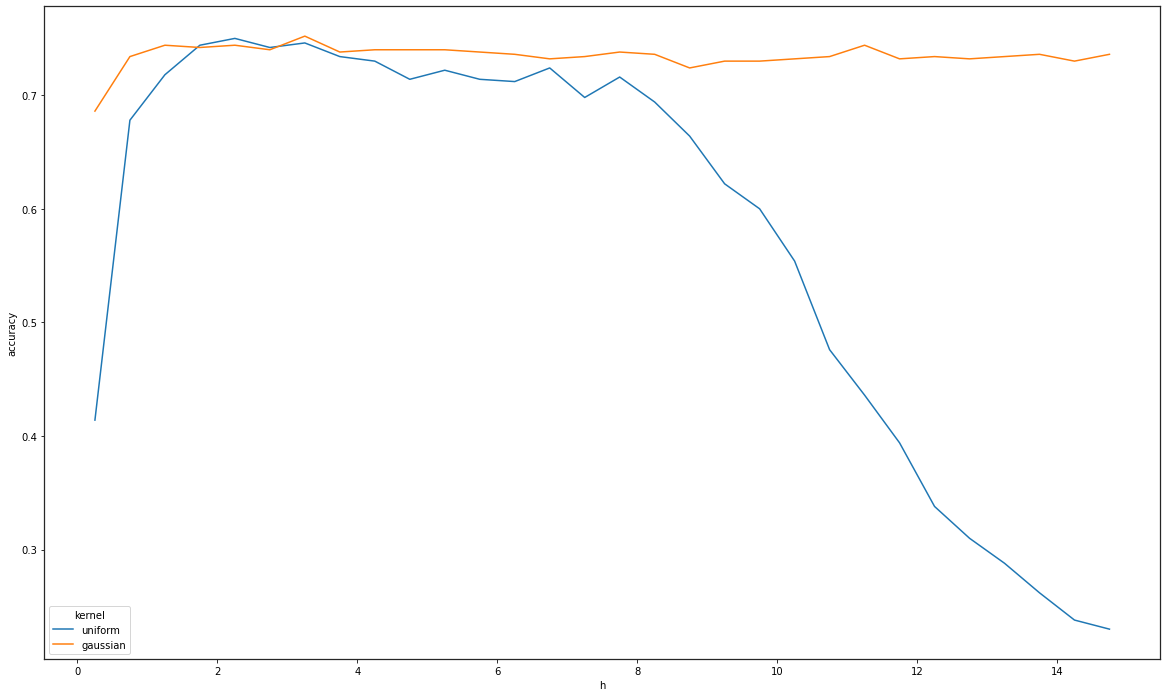

In [21]:
from parzen import Parzen
Parzen.hyperparameter_search(
    tp3, 
    kf,
    h=np.arange(0.25, 15, 0.5),
    kernel=["uniform", "gaussian"]
)

Le modèle le plus performant semble être celui avec la fonction gaussienne et un $h>1$. Notre analyse plus haut était donc la meilleure que l'on puisse tirer de ce modèle. On remarque également que pour $h=2,5$, les performances semblent sensiblement identiques, peu importe la fonction choisie. On remarque également que le choix du $h$ semble peu impacter la performance de la fonction gaussienne, alors qu'un $h>8$ diminue grandement les performances de la fonction uniforme.

Enfin, une méthode d'améliorer notre modèle est d'utiliser une méthode d'ensembles.

# Bagging

L'objectif est d'entrainer $n$ modèles sur une petite portion aléatoire prélevée dans le datasets, puis d'aggréger les prédictions lors de l'inférence.

Nous commençons par l'utiliser sur le Perceptron, et nous souhaitons déterminer la meilleure proportion (10%, 15% et 20%) du dataset utiliser à chaque itération, ainsi que le nombre de modèles utiliser (entre 1 et 50).

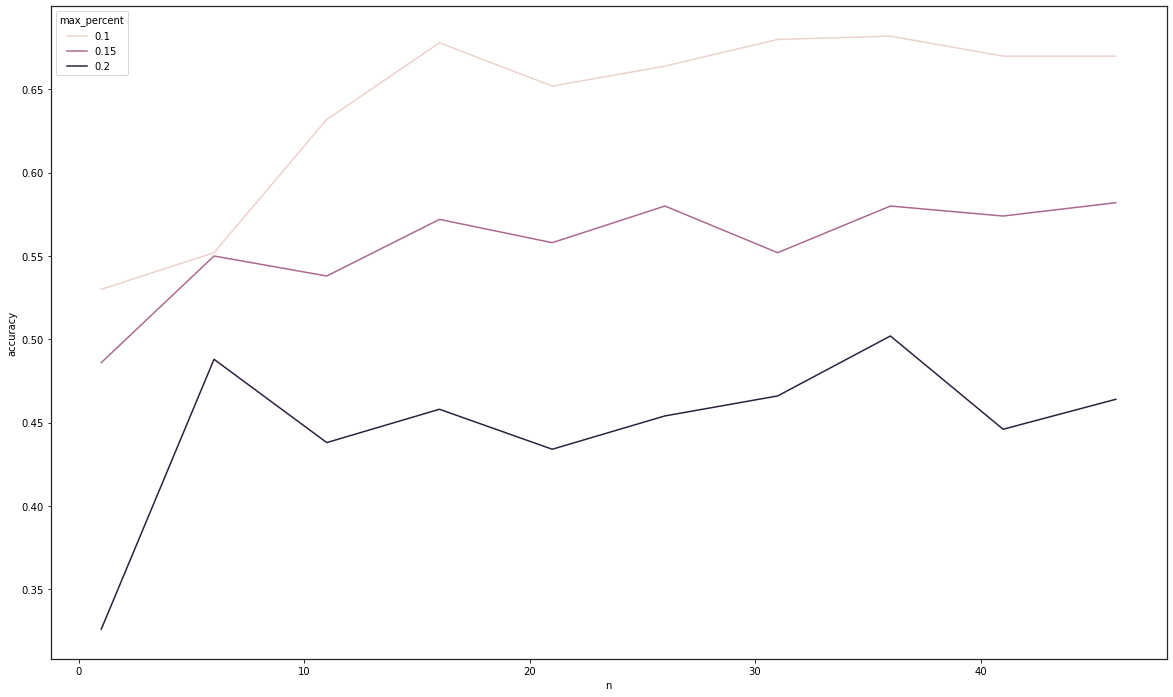

In [32]:
from bagging import Bagging
from perceptron import Perceptron

Bagging.hyperparameter_search(
    tp3, 
    kf,
    Perceptron,
    n=np.arange(1, 51, 5),
    max_percent=[.1, .15, .2]
)

A la vue de ces courbes, on peut voir que plus la fraction du dataset utilisée est faible, plus notre bagging sera performant. Ceci est logique car il permet d'apporter une plus grande diversité entre les modèles.

De plus, notre meilleur modèle semble ici être avec les paramètres $n=36$ et $p=10$%. Nous allons donc évaluer ce modèle sur nos données.

name         hyperparameters dataset  top1_acc  top2_acc
0  Bagging  model=Perceptron, n=36     tp1     0.966     0.996
1  Bagging  model=Perceptron, n=36     tp2     0.920     0.994
2  Bagging  model=Perceptron, n=36     tp3     0.660     0.882

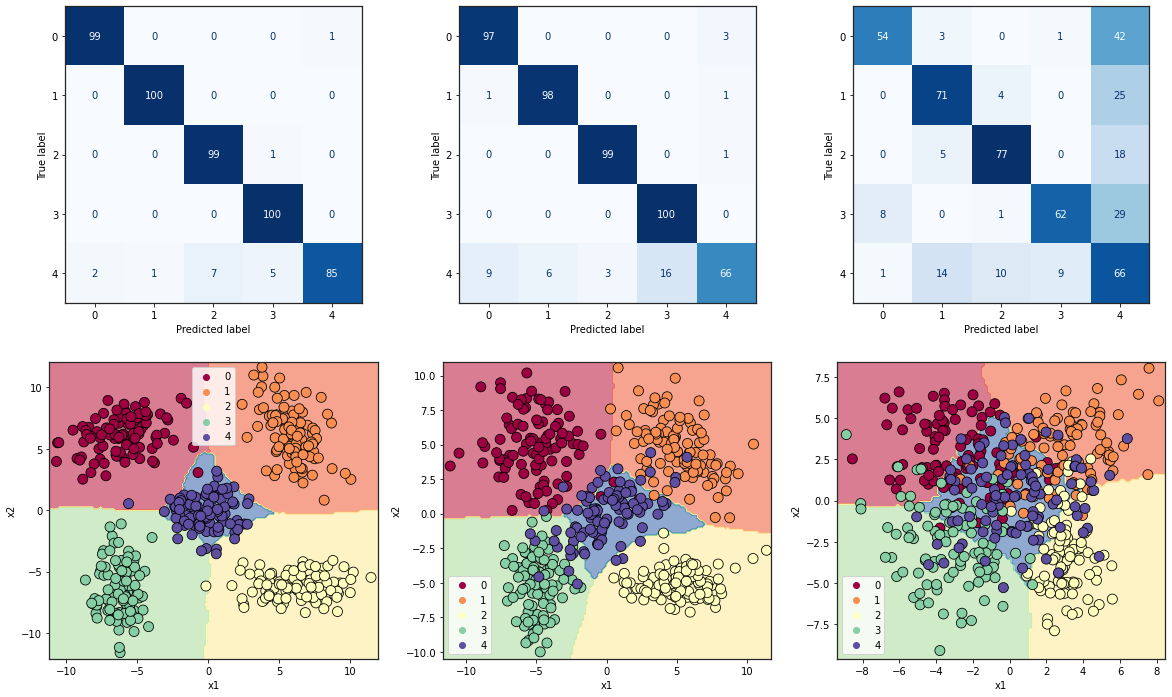

In [33]:
results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = Bagging(Perceptron, 36, max_percent = 0.1)
    model.train(train)
    results.append(model.evaluate(test, axs=(axs[0,i], axs[1,i])))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

On peut voir sur ces figures que grâce au Bagging, les performances sur les datasets 2 et 3 sont nettement améliorées par rapport au Perceptron seul, pour réussir à obtenir des précisions quasi-similaires aux autres modèles. Le Bagging a donc dans notre cas fonctionné, et on retrouve des limites de décisions bien plus cohérentes qu'avec notre précédent exemple du Perceptron seul où le modèle attribuait la classe 4 quasi-systématiquement. La limite de décision notamment liée à la classe 4 (tp3) est grandement diminuée, ce qui peut s'expliquer par le fait que réduire le nombre de points lors de l'entrainement permet d'identifier une droite plus fiable.

Nous allons maintenant comparer avec un Bagging de KPPV à $k=21$.

name   hyperparameters dataset  top1_acc  top2_acc
0  Bagging  model=KPPV, n=36     tp1     0.992     1.000
1  Bagging  model=KPPV, n=36     tp2     0.942     0.996
2  Bagging  model=KPPV, n=36     tp3     0.712     0.884

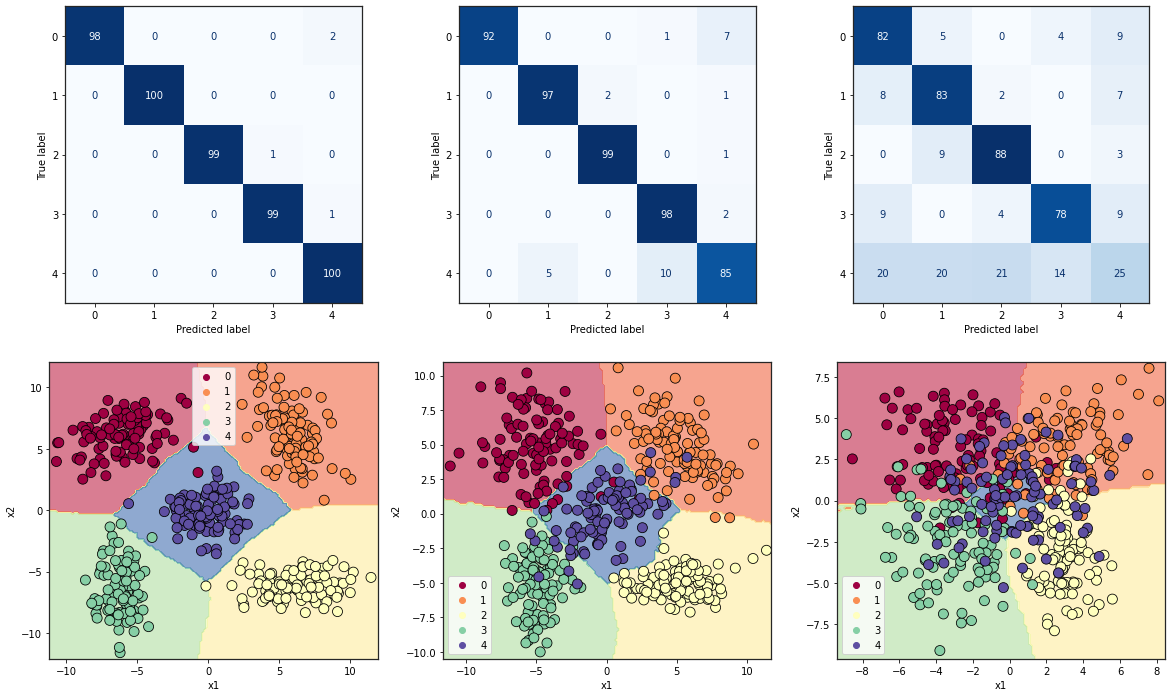

In [34]:
results = []
fig, axs = plt.subplots(nrows=2, ncols=3)
for i, (train, test) in enumerate(datasets):
    model = Bagging(KPPV, 36, max_percent = 0.1, k=21)
    model.train(train)
    results.append(model.evaluate(test, axs=(axs[0,i], axs[1,i])))

evaluation = evaluation.append(results, ignore_index=True)
pd.DataFrame(results)

Comme ces résultats le montrent, aucune amélioration de performance par rapport au KPPV avec $k=21$ seul n'est observée. Ceci peut s'expliquer par le fait que le Bagging n'améliore les performances que des modèles instables comme la séparation linéaire, alors que le KPPV est déjà un modèle stable.

## Conclusion

Après avoir déterminé les meilleurs hyperparamètres, puis évalué chacun des modèles. Nous pouvons récapituler toutes les performances obtenus, pour les 3 datasets, dans ce tableau :

In [35]:
final = evaluation.pivot_table(values = "top1_acc", 
                       index = ["name", "hyperparameters"], 
                       columns = "dataset")
final

dataset                                      tp1     tp2    tp3
name              hyperparameters                              
Bagging           model=KPPV, n=36        0.9920  0.9420  0.712
                  model=Perceptron, n=36  0.9660  0.9200  0.660
GaussianEstimator distance=euclidian      0.9920  0.9460  0.728
                  distance=mahalanobis    0.9960  0.9460  0.698
KPPV              k=1                     0.9920  0.9200  0.646
                  k=21                    0.9960  0.9460  0.712
Parzen            h=2, kernel=gaussian    0.9960  0.9520  0.724
                  h=2, kernel=uniform     0.9900  0.9480  0.702
Perceptron        versus=all              0.9625  0.8225  0.375
                  versus=one              0.9840  0.6480  0.278

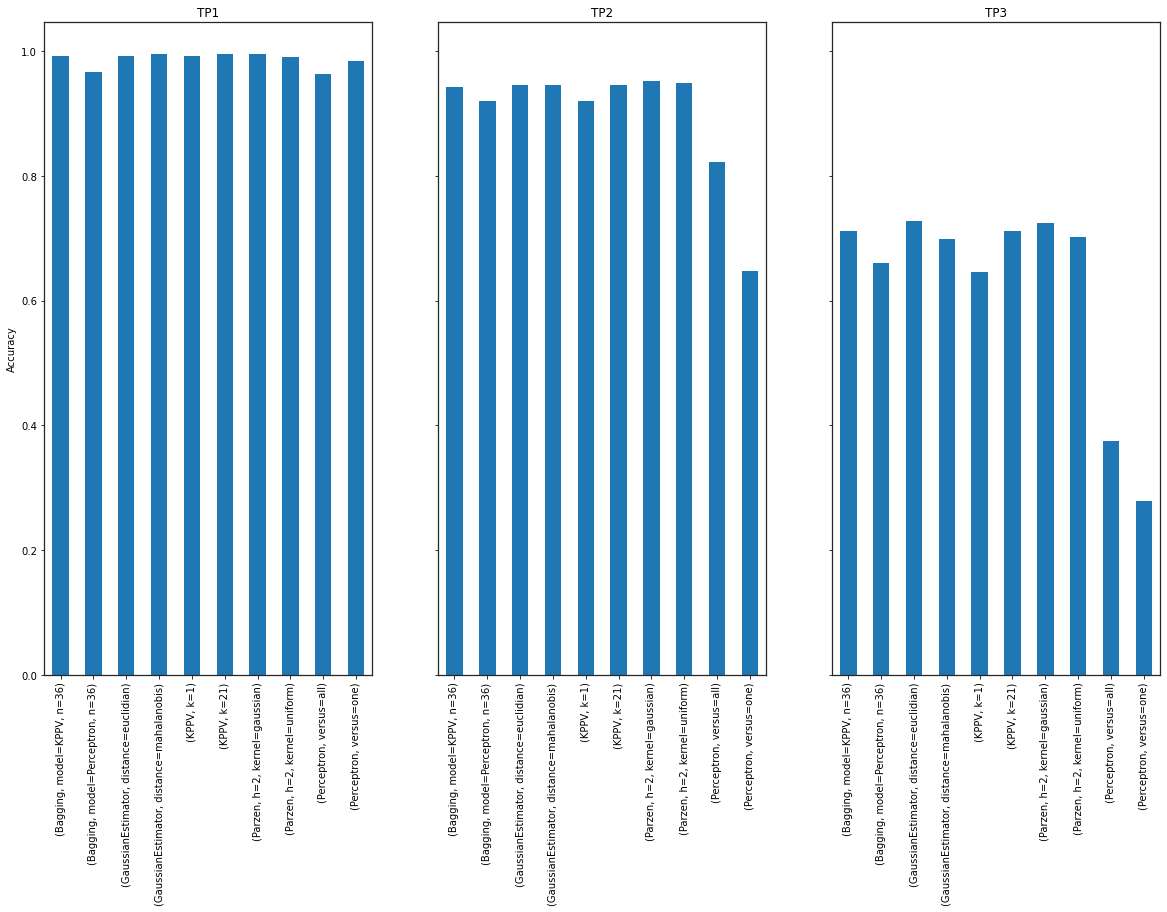

In [70]:
fig, axs = plt.subplots(ncols=3, sharey=True)
final.tp1.plot.bar(ax = axs[0], title="TP1", ylabel="Accuracy", xlabel="")
final.tp2.plot.bar(ax = axs[1], title="TP2", xlabel="")
final.tp3.plot.bar(ax = axs[2], title="TP3", xlabel="");

Globalement, on peut observer que les performances sont toutes proches entre les différents modèles, sauf le Perceptron qui présente une performance inférieure sur les jeux de données 2 et 3, que ce soit en `one vs one` ou en `one vs all`.

In [36]:
final.idxmax().to_frame(name="Meilleur modèle")

Meilleur modèle
dataset                                           
tp1      (GaussianEstimator, distance=mahalanobis)
tp2                 (Parzen, h=2, kernel=gaussian)
tp3        (GaussianEstimator, distance=euclidian)

Finalement, on peut voir que :

- C'est l'estimation gaussienne avec la distance de Mahalnobis qui est le meilleur modèle sur le premier dataset (même si l'écart entre chaque modèle est minime)
- C'est Parzen avec $h=2$ et une fonction Gaussienne qui est le meilleur modèle sur le 2ème dataset (encore une fois, l'écart hors Perceptron n'est variable que de 2%)
- C'est l'estimation gaussienne avec distance euclidienne qui est le meilleur modèle sur le 3ème jeu de données, mais de peu devant l'estimation Gaussienne à distance euclidienne.

En voyant ces différences selon le modèle, on peut conclure qu'il est donc important et pertinent d'évaluer plusieurs architectures de modèles sans avoir de trop gros *a priori* sur les méthodes de classification, car leur performance dépend aussi du jeu de données.